In [1]:
import json
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import hmean

In [2]:
# Load JSON data
with open('github_stargazers/git_edges.json', 'r') as f:
    graph_data = json.load(f)
    
# Load targets CSV
labels_df = pd.read_csv('github_stargazers/git_target.csv')

In [3]:
# Function to create NetworkX graph from edges
def create_graph(edges):
    G = nx.Graph()
    G.add_edges_from(edges)
    return G

In [4]:
# Analysis on each graph
node_counts, edge_counts, densities, diameters, clustering_coeffs = [], [], [], [], []
for graph_id, edges in graph_data.items():
    G = create_graph(edges)
    node_counts.append(G.number_of_nodes())
    edge_counts.append(G.number_of_edges())
    densities.append(nx.density(G))
    diameters.append(nx.diameter(G) if nx.is_connected(G) else float('inf'))
    clustering_coeffs.append(nx.average_clustering(G))

# Create a DataFrame for visualization
graph_analysis_df = pd.DataFrame({
    'id': graph_data.keys(),
    'nodes': node_counts,
    'edges': edge_counts,
    'density': densities,
    'diameter': diameters,
    'clustering_coeff': clustering_coeffs
})



/Users/oleksiionishchenko/Documents/ownprojects/sidestuff/DataAnalysis/NetworkAnalysis/venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


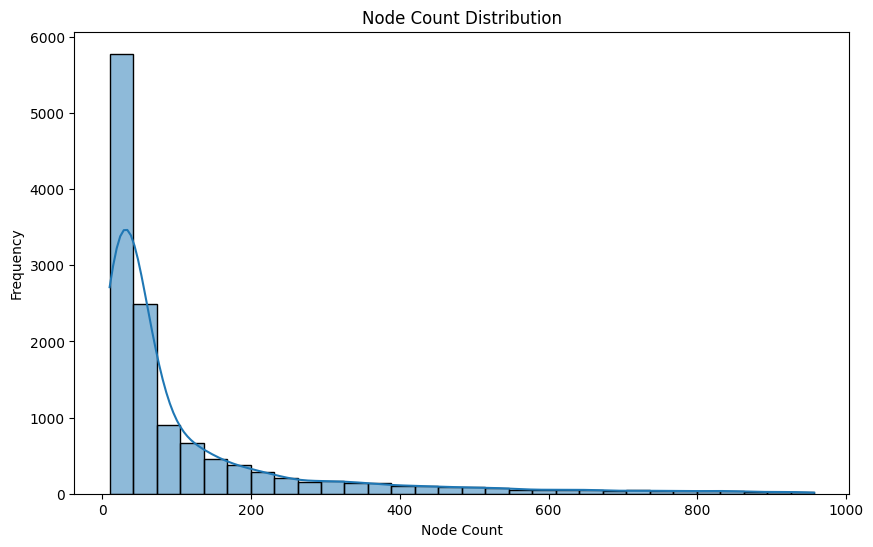

Columns in data_with_labels: Index(['id', 'nodes', 'edges', 'density', 'diameter', 'clustering_coeff',
       'label'],
      dtype='object')


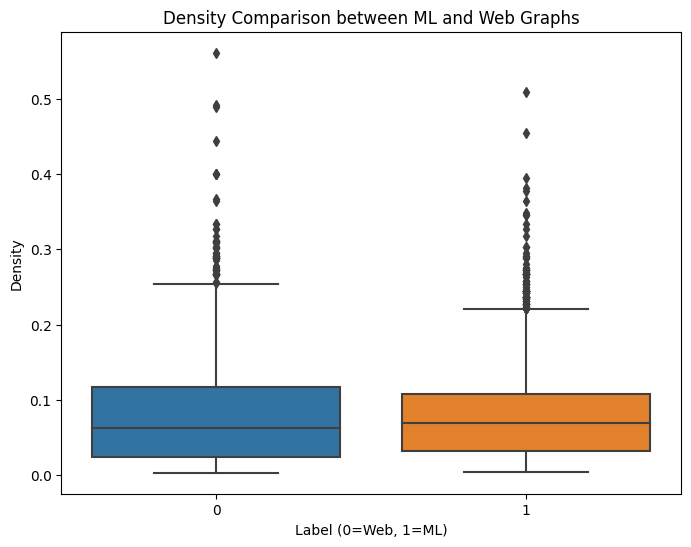

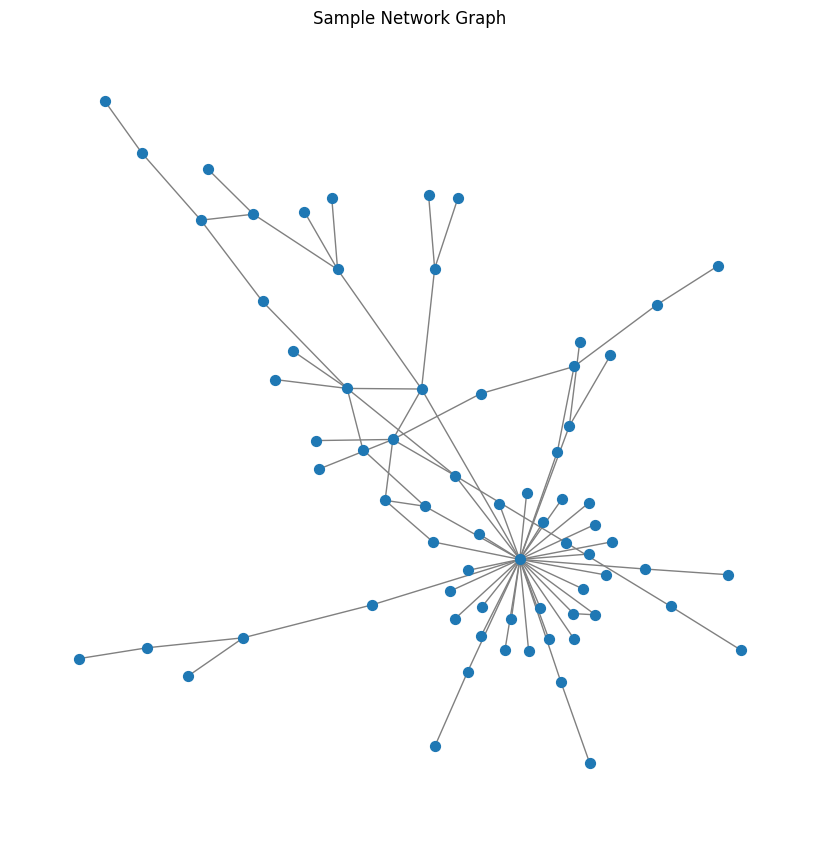

In [5]:
# Ensure 'id' columns in both DataFrames are of the same type (string)
graph_analysis_df['id'] = graph_analysis_df['id'].astype(str)
labels_df['id'] = labels_df['id'].astype(str)

# Now merge on 'id'
data_with_labels = pd.merge(graph_analysis_df, labels_df, on='id')

# Visualization: Histogram for node count distribution
plt.figure(figsize=(10, 6))
sns.histplot(data_with_labels['nodes'], bins=30, kde=True)
plt.title('Node Count Distribution')
plt.xlabel('Node Count')
plt.ylabel('Frequency')
plt.show()

# Ensure the 'label' column exists and is correctly named in labels_df
if 'label' not in labels_df.columns:
    # If the column is named differently, rename it to 'label'
    labels_df.rename(columns={'target': 'label'}, inplace=True)  # Change 'target' to the actual column name if different

# Check columns in data_with_labels after merging
data_with_labels = pd.merge(graph_analysis_df, labels_df, on='id')
print("Columns in data_with_labels:", data_with_labels.columns)

# If 'label' column is present, proceed with the box plot
if 'label' in data_with_labels.columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='label', y='density', data=data_with_labels)
    plt.title('Density Comparison between ML and Web Graphs')
    plt.xlabel('Label (0=Web, 1=ML)')
    plt.ylabel('Density')
    plt.show()
else:
    print("Error: 'label' column not found in data_with_labels after merging.")


# Plot a sample network graph
sample_edges = list(graph_data.values())[0]  # Select the first graph
G_sample = create_graph(sample_edges)
plt.figure(figsize=(8, 8))
nx.draw(G_sample, node_size=50, edge_color='grey', with_labels=False)
plt.title('Sample Network Graph')
plt.show()

In [6]:
# Split data by class
web_data = data_with_labels[data_with_labels['label'] == 0]
ml_data = data_with_labels[data_with_labels['label'] == 1]

# Calculate harmonic means for each parameter
parameters = ['nodes', 'edges', 'density', 'diameter', 'clustering_coeff']

web_harmonic_means = {param: hmean(web_data[param].replace(0, float('nan')).dropna()) for param in parameters}
ml_harmonic_means = {param: hmean(ml_data[param].replace(0, float('nan')).dropna()) for param in parameters}

# Display results
print("Harmonic Means for Web (0):", web_harmonic_means)
print("Harmonic Means for ML (1):", ml_harmonic_means)


Harmonic Means for Web (0): {'nodes': 33.64222651542776, 'edges': 39.29714664863373, 'density': 0.02916907604167776, 'diameter': 5.1294605260499875, 'clustering_coeff': 0.12031631008898618}
Harmonic Means for ML (1): {'nodes': 35.56540766995437, 'edges': 43.24796451582372, 'density': 0.03604787922953422, 'diameter': 5.338239335147458, 'clustering_coeff': 0.1459993814160416}


In [7]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"


In [8]:
import tensorflow as tf
import tensorflow_gnn as tfgnn
from tensorflow_gnn import runner
import numpy as np
from tensorflow.keras import layers

In [13]:
labels_dict = dict(zip(labels_df['id'], labels_df['label']))

In [14]:
# Define the node set specification
node_set_spec = tfgnn.NodeSetSpec.from_field_specs(
    features_spec={},
    sizes_spec=tf.TensorSpec(shape=[None], dtype=tf.int32)
)

# Define the edge set specification
edge_set_spec = tfgnn.EdgeSetSpec.from_field_specs(
    features_spec={},
    sizes_spec=tf.TensorSpec(shape=[None], dtype=tf.int32),
    adjacency_spec=tfgnn.AdjacencySpec.from_incident_node_sets(
        source_node_set='nodes',
        target_node_set='nodes',
        index_spec=tf.TensorSpec(shape=[None], dtype=tf.int32)
    )
)

# Create the GraphTensorSpec
graph_tensor_spec = tfgnn.GraphTensorSpec.from_piece_specs(
    node_sets_spec={'nodes': node_set_spec},
    edge_sets_spec={'edges': edge_set_spec}
)

In [47]:
import tensorflow_gnn as tfgnn
import tensorflow as tf

def json_to_graph_tensor(graph_data):
    edges = graph_data
    num_nodes = max(max(edge) for edge in edges) + 1  # Estimate the number of nodes

    # Create NodeSet without features initially
    node_set = tfgnn.NodeSet.from_fields(sizes=[num_nodes], features={})

    # Create EdgeSet based on edges
    edge_set = tfgnn.EdgeSet.from_fields(
        sizes=[len(edges)],
        features={},
        adjacency=tfgnn.Adjacency.from_indices(
            source=("nodes", [edge[0] for edge in edges]),
            target=("nodes", [edge[1] for edge in edges])
        )
    )

    # Build and return the GraphTensor
    return tfgnn.GraphTensor.from_pieces(node_sets={"nodes": node_set}, edge_sets={"edges": edge_set})


In [44]:
def dataset_generator(graphs, labels_dict):
    for graph_id, edges in graphs.items():
        graph_tensor = json_to_graph_tensor(edges)
        label = labels_dict[int(graph_id)]
        yield graph_tensor, label

# Assuming 'graphs' is your JSON data and 'labels_dict' is your labels dictionary
dataset = tf.data.Dataset.from_generator(
    lambda: dataset_generator(graph_data, labels_dict),
    output_signature=(
        graph_tensor_spec,
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )
).batch(32)

In [45]:
from tensorflow.keras import layers, models

def build_gnn_model():
    # Define the input with GraphTensorSpec
    inputs = tf.keras.Input(type_spec=graph_tensor_spec)

    # Use GraphUpdate with explicit zero-initialized state
    graph_updates = tfgnn.keras.layers.GraphUpdate(
        node_sets={
            "nodes": tfgnn.keras.layers.NodeSetUpdate(
                # Initialize hidden_state with zeros within NodeSetUpdate
                edge_set_inputs={
                    "edges": tfgnn.keras.layers.Pool(
                        tfgnn.SOURCE, reduce_type="mean"
                    )
                }
            )
        }
    )(inputs)

    # Pooling to get a single graph-level representation
    graph_embeddings = tfgnn.keras.layers.Pool("nodes", tfgnn.CONTEXT, reduce_type="mean")(graph_updates)

    # Output layer for binary classification
    output = layers.Dense(1, activation="sigmoid")(graph_embeddings)

    # Create the model
    model = models.Model(inputs=inputs, outputs=output)

    return model

# Build and compile the model
model = build_gnn_model()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Train the model with the dataset
model.fit(dataset, epochs=10)


ValueError: NodeSetUpdate(next_state=... must be a tf.keras.layer.Layer, got type: function

In [59]:
# graph_schema = tfgnn.read_schema("github_stargazers/git_edges.json")

In [ ]:
# graph_schema = tfgnn.read_schema("/github/git_edges.json")
# gtspec = tfgnn.create_graph_spec_from_schema_pb(graph_schema)


# # len(train_ds_provider.get_dataset(...)) == 8191.
# train_ds_provider = runner.TFRecordDatasetProvider(file_pattern="...")
# # len(valid_ds_provider.get_dataset(...)) == 1634.
# valid_ds_provider = runner.TFRecordDatasetProvider(file_pattern="...")


# # Use `embedding` feature as the only node feature.
# initial_node_states = lambda node_set, node_set_name: node_set["embedding"]


# map_features = tfgnn.keras.layers.MapFeatures(node_sets_fn=initial_node_states)


# # Binary classification by the root node.
# task = runner.RootNodeBinaryClassification(
#     "nodes",
#     label_fn=runner.ContextLabelFn("label"))


# trainer = runner.KerasTrainer(
#     strategy=tf.distribute.TPUStrategy(...),
#     model_dir="...",
#     steps_per_epoch=8191 // 128,  # global_batch_size == 128
#     validation_per_epoch=2,
#     validation_steps=1634 // 128)  # global_batch_size == 128


# runner.run(
#     train_ds_provider=train_ds_provider,
#     train_padding=runner.FitOrSkipPadding(gtspec, train_ds_provider),
#     # model_fn is a function: Callable[[tfgnn.GraphTensorSpec], tf.keras.Model].
#     # Where the returned model both takes and returns a scalar `GraphTensor` for
#     # its inputs and outputs.
#     model_fn=model_fn,
#     optimizer_fn=tf.keras.optimizers.Adam,
#     epochs=4,
#     trainer=trainer,
#     task=task,
#     gtspec=gtspec,
#     global_batch_size=128,
#     feature_processors=[map_features],
#     valid_ds_provider=valid_ds_provider)


In [46]:
# Step 1: Prepare GraphTensor Objects from Edge Lists
def create_graph_tensor(edges, num_nodes):
    """Creates a GraphTensor from a list of edges."""
    # Convert edges to adjacency format
    edge_indices = np.array(edges, dtype=np.int32)
    
    # Initialize the "hidden_state" feature for nodes as a zero vector (e.g., 16-dimensional)
    node_features = {"hidden_state": tf.zeros([num_nodes, 16], dtype=tf.float32)}
    
    # Create a context with sizes to avoid shape mismatch issues
    context = tfgnn.Context.from_fields(
        features={}, 
        sizes=tf.constant([1], dtype=tf.int32)  # Single graph per example
    )
    
    # Create the GraphTensor with edges, initialized node features, and context
    graph_tensor = tfgnn.GraphTensor.from_pieces(
        context=context,
        node_sets={
            "nodes": tfgnn.NodeSet.from_fields(
                features=node_features,
                sizes=tf.constant([num_nodes])  # Number of nodes inferred from edge indices
            )
        },
        edge_sets={
            "edges": tfgnn.EdgeSet.from_fields(
                sizes=tf.constant([len(edges)]),  # Number of edges
                adjacency=tfgnn.Adjacency.from_indices(
                    source=("nodes", edge_indices[:, 0]),
                    target=("nodes", edge_indices[:, 1])
                ),
                features={}  # No edge features
            )
        }
    )
    return graph_tensor

In [47]:
# Generate GraphTensors and labels
graph_tensors = []
labels = []

for graph_id, edges in graph_data.items():
    num_nodes = max(max(u, v) for u, v in edges) + 1  # Calculate the number of nodes
    graph_tensor = create_graph_tensor(edges, num_nodes)
    graph_tensors.append(graph_tensor)
    label = labels_df[labels_df['id'] == graph_id]['label'].values[0]
    labels.append(label)


In [48]:
# Step 2: Create a Dataset Generator
def graph_tensor_generator():
    """A generator that yields GraphTensors and their labels."""
    for tensor, label in zip(graph_tensors, labels):
        yield tensor, label

# Create Dataset from the generator
dataset = tf.data.Dataset.from_generator(
    graph_tensor_generator,
    output_signature=(
        graph_tensors[0].spec,  # The spec of a GraphTensor
        tf.TensorSpec(shape=(), dtype=tf.int32)  # Label is a single integer
    )
).shuffle(buffer_size=1024).batch(8)

In [53]:
# Step 3: Define GNN Model for Graph Classification
def create_gnn_model():
    # Define a GNN layer (Graph Convolution or GraphSAGE) using tfgnn.keras.layers.GraphUpdate
    gnn_layer = tfgnn.keras.layers.GraphUpdate(
        node_sets={"nodes": tfgnn.keras.layers.NodeSetUpdate(
            {  # Define edge-specific transformations
                "edges": tfgnn.keras.layers.SimpleConv(
                    layers.Dense(16),  # Dense transformation for each edge
                    receiver_tag=tfgnn.TARGET
                )
            },
            tfgnn.keras.layers.NextStateFromConcat(layers.Dense(16))
        )}
    )
    
    # Build the model
    inputs = tf.keras.Input(type_spec=graph_tensors[0].spec)
    x = gnn_layer(inputs)
    
    # Pooling to obtain a graph-level representation
    x = tfgnn.keras.layers.Pool(tfgnn.CONTEXT,"mean", name="global_pooling")(x, node_set_name="nodes")
    x = layers.Dense(32, activation="relu")(x)
    x = layers.Dense(2, activation="softmax")(x)  # Binary classification output

    model = tf.keras.Model(inputs=inputs, outputs=x)
    return model

In [54]:
model = create_gnn_model()

In [55]:
# Step 3: Compile and Train the Model
# Compile model with appropriate loss and optimizer for binary classification
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"]
)

In [56]:
# Train the model
model.fit(dataset, epochs=10, steps_per_epoch=len(labels) // 8)

Epoch 1/10


ValueError: in user code:

    File "/Users/oleksiionishchenko/Documents/ownprojects/sidestuff/DataAnalysis/NetworkAnalysis/venv/lib/python3.12/site-packages/tf_keras/src/engine/training.py", line 1398, in train_function  *
        return step_function(self, iterator)
    File "/Users/oleksiionishchenko/Documents/ownprojects/sidestuff/DataAnalysis/NetworkAnalysis/venv/lib/python3.12/site-packages/tf_keras/src/engine/training.py", line 1370, in run_step  *
        outputs = model.train_step(data)
    File "/Users/oleksiionishchenko/Documents/ownprojects/sidestuff/DataAnalysis/NetworkAnalysis/venv/lib/python3.12/site-packages/tf_keras/src/engine/training.py", line 1147, in train_step  *
        y_pred = self(x, training=True)
    File "/Users/oleksiionishchenko/Documents/ownprojects/sidestuff/DataAnalysis/NetworkAnalysis/venv/lib/python3.12/site-packages/tf_keras/src/engine/training.py", line 565, in error_handler  *
        del filtered_tb
    File "/Users/oleksiionishchenko/Documents/ownprojects/sidestuff/DataAnalysis/NetworkAnalysis/venv/lib/python3.12/site-packages/tf_keras/src/engine/training.py", line 588, in __call__  *
        return super().__call__(*args, **kwargs)
    File "/Users/oleksiionishchenko/Documents/ownprojects/sidestuff/DataAnalysis/NetworkAnalysis/venv/lib/python3.12/site-packages/tf_keras/src/engine/training.py", line 565, in error_handler  *
        del filtered_tb
    File "/Users/oleksiionishchenko/Documents/ownprojects/sidestuff/DataAnalysis/NetworkAnalysis/venv/lib/python3.12/site-packages/tf_keras/src/engine/base_layer.py", line 1136, in __call__  *
        outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/oleksiionishchenko/Documents/ownprojects/sidestuff/DataAnalysis/NetworkAnalysis/venv/lib/python3.12/site-packages/tf_keras/src/engine/functional.py", line 514, in call  *
        return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/Users/oleksiionishchenko/Documents/ownprojects/sidestuff/DataAnalysis/NetworkAnalysis/venv/lib/python3.12/site-packages/tf_keras/src/engine/functional.py", line 671, in _run_internal_graph  *
        outputs = node.layer(*args, **kwargs)
    File "/Users/oleksiionishchenko/Documents/ownprojects/sidestuff/DataAnalysis/NetworkAnalysis/venv/lib/python3.12/site-packages/tf_keras/src/engine/training.py", line 560, in error_handler  *
        filtered_tb = _process_traceback_frames(e.__traceback__)
    File "/Users/oleksiionishchenko/Documents/ownprojects/sidestuff/DataAnalysis/NetworkAnalysis/venv/lib/python3.12/site-packages/tf_keras/src/engine/base_layer.py", line 1136, in __call__  *
        outputs = call_fn(inputs, *args, **kwargs)
    File "/var/folders/kb/78bg59vd3d13th1nchzy26m00000gn/T/__autograph_generated_filea3muxaod.py", line 162, in error_handler  **
        raise ag__.converted_call(ag__.ld(new_e).with_traceback, (ag__.ld(e).__traceback__,), None, fscope_1) from None
    File "/var/folders/kb/78bg59vd3d13th1nchzy26m00000gn/T/__autograph_generated_filea3muxaod.py", line 34, in error_handler
        retval__1 = ag__.converted_call(ag__.ld(fn), tuple(ag__.ld(args)), dict(**ag__.ld(kwargs)), fscope_1)
    File "/var/folders/kb/78bg59vd3d13th1nchzy26m00000gn/T/__autograph_generated_file98kd0rcf.py", line 26, in tf__call  **
        ag__.converted_call(ag__.ld(gt).check_scalar_graph_tensor, (ag__.ld(graph), 'GraphUpdate'), None, fscope)
    File "/var/folders/kb/78bg59vd3d13th1nchzy26m00000gn/T/__autograph_generated_file1l4x2_li.py", line 10, in tf__check_scalar_graph_tensor  **
        ag__.converted_call(ag__.ld(gp).check_scalar_graph_piece, (ag__.ld(graph),), dict(name=ag__.ld(name)), fscope)
    File "/Users/oleksiionishchenko/Documents/ownprojects/sidestuff/DataAnalysis/NetworkAnalysis/venv/lib/python3.12/site-packages/tensorflow_gnn/graph/graph_piece.py", line 1300, in check_scalar_graph_piece  **
        raise ValueError(

    ValueError: Exception encountered when calling layer 'graph_update_12' (type GraphUpdate).
    
    GraphUpdate requires a scalar GraphTensor, that is, with `GraphTensor.rank=0`, but got `rank=1`. Use GraphTensor.merge_batch_to_components() to merge all contained graphs into one contiguously indexed graph of the scalar GraphTensor.
    
    Call arguments received by layer 'graph_update_12' (type GraphUpdate):
      • graph=GraphTensor(
      context=Context(features={}, sizes=Tensor("IteratorGetNext:0", shape=(None, 1), dtype=int32), shape=(None,), indices_dtype=tf.int32),
      node_set_names=['nodes'],
      edge_set_names=['edges'])


In [ ]:
# Evaluation
# Ideally, you'd split the dataset into training and test sets, but for simplicity, let's use the same data here.
evaluation = model.evaluate(dataset)
print("Evaluation Results:", evaluation)